In [1]:
import findspark
findspark.init()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from pyspark import SparkContext
from pyspark.conf import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.sql.functions import regexp_extract, col

from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [3]:
sc = SparkContext()
spark = SparkSession(sc)

In [4]:
df = spark.read.csv("../../Data/2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

In [5]:
df_sub = df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 
                   'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES', 
                   'ASSUMABLEMORTGAGE', 'SalesClosePrice', 'ListPrice',
                   'DAYSONMARKET')

In [6]:
df_sub.show(5)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|               8583|         0|          120x296|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|               9350|         1|          208X208|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|               2915|         1|          116x200|Exclusive Right|  0.0|             null|

### Xóa các thuộc tính không liên quan

In [7]:
# Drop columns in list
df_sub = df_sub.drop(*['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS'])
df_sub.show(5)

+----------+---------------+-----+-----------------+---------------+---------+------------+
|FIREPLACES|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+----------+---------------+-----+-----------------+---------------+---------+------------+
|         0|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|         0|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|         0|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|         1|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|         1|Exclusive Right|  0.0|             null|         249900|   239900|          21|
+----------+---------------+-----+-----------------+---------------+---------+------------+
only showing top 5 rows



### Lọc dữ liệu

In [8]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df_sub.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [9]:
print("Before:", df_sub.count())
# List of the possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']
# Filter the text values out of df_sub but keep null values
text_filter = ~df_sub['ASSUMABLEMORTGAGE'].isin(yes_values) | df_sub['ASSUMABLEMORTGAGE'].isNull()
df_sub = df.where(text_filter)
# Print counth of remaining records
print("After:", df_sub.count())

Before: 5000
After: 4976


### Xóa dữ liệu outlier theo phân phối chuẩn

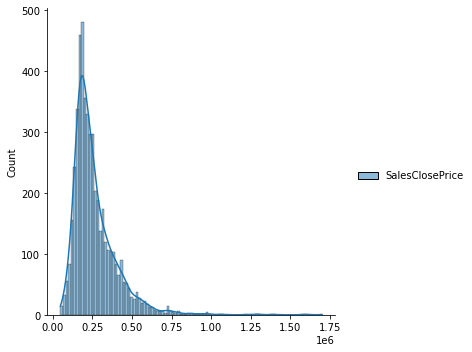

In [10]:
sns.displot(df_sub.select(['SalesClosePrice']).toPandas(), kde=True)

In [11]:
df_sub = df_sub.withColumn("Log_ScaleClosePrice", log(col("SalesClosePrice")))
df_sub.count()

4976

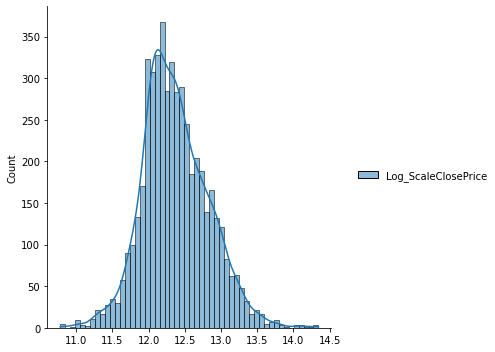

In [12]:
sns.displot(df_sub.select(["Log_ScaleClosePrice"]).toPandas(), kde=True)

In [13]:
# Calculate values used for outlier filtering
mean_val = df_sub.agg({'Log_ScaleClosePrice': 'mean'}).collect()[0][0]
stddev_val = df_sub.agg({'Log_ScaleClosePrice': 'stddev'}).collect()[0][0]
# Create three standard deviation lower and upper bounds for data
low_bound = mean_val - (3* stddev_val)
high_bound = mean_val + (3* stddev_val)
# Filter the data to fit between the lower and upper bounds
df_sub = df_sub.where((df_sub['Log_ScaleClosePrice'] < high_bound) & (df_sub['Log_ScaleClosePrice'] > low_bound))

{'whiskers': [<matplotlib.lines.Line2D at 0x1cfd6af28e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cfd6af2fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cfd6af2580>],
 'medians': [<matplotlib.lines.Line2D at 0x1cfd6b5c6a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cfd6b5ca00>],
 'means': []}

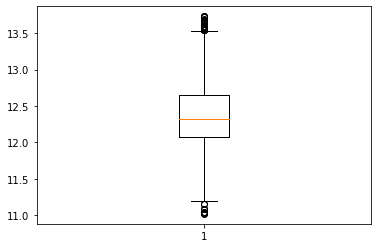

In [14]:
plt.boxplot(df_sub.select(['Log_ScaleClosePrice']).toPandas())

In [15]:
df_sub.count()

4946

In [16]:
# Drop records if both ListPrice and SalesClosePrice is null
df_sub = df_sub.dropna(how='all', subset=['ListPrice', 'SalesClosePrice'])

In [17]:
# Drop records where at least 2 columns have NULL values
df_sub = df_sub.dropna(thresh=2)

### MinMax Scaling

In [18]:
print(df_sub.agg({'SalesClosePrice': 'max'}).collect())
print(df_sub.agg({'SalesClosePrice': 'min'}).collect())

[Row(max(SalesClosePrice)=920000)]
[Row(min(SalesClosePrice)=61000)]


In [19]:
# Define max and min values and collect them
max_price = df_sub.agg({'SalesClosePrice': 'max'}).collect()[0][0]
min_price = df_sub.agg({'SalesClosePrice': 'min'}).collect()[0][0]

In [20]:
# Create a new column based off the scaled data
df_sub = df_sub.withColumn('scaled_price', (df_sub['SalesClosePrice'] - min_price) / (max_price - min_price))
# Calculate max and min for new column
print(df_sub.agg({'scaled_price': 'max'}).collect())
print(df_sub.agg({'scaled_price': 'min'}).collect())

[Row(max(scaled_price)=1.0)]
[Row(min(scaled_price)=0.0)]


### Hiển thị dữ liệu thiếu

In [21]:
roof = df[['ROOF']]
roof.where(df['ROOF'].isNull()).count()

765

<AxesSubplot:>

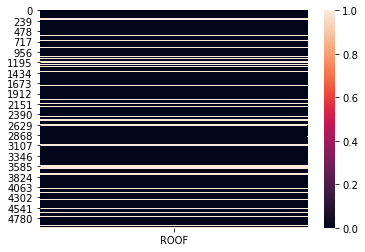

In [23]:
roof_df = roof.toPandas()
sns.heatmap(data=roof_df.isnull())